# 说明  
notebook配套教程第五章和第六章，将结合U-Net模型来探索PyTorch的模型定义方式和进阶训练技巧。  
下方每个“Point”对应于教程中每一节的内容。

In [1]:
import os
import numpy as np
import collections
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

**Point 1：模型定义方式**  
PyTorch中自定义模型主要通过以下三种方式：  
- Sequential  
- ModuleList  
- ModuleDict

In [ ]:
## 讲解点：使用ordered dict更有助于一目了然模型结构，对于之后模型修改也非常有帮助

In [2]:
## Sequential: Direct list
import torch.nn as nn
net1 = nn.Sequential(
        nn.Linear(784, 256),
        nn.ReLU(),
        nn.Linear(256, 10), 
        )
print(net1)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=10, bias=True)
)


In [3]:
## Sequential: Ordered Dict
import collections
import torch.nn as nn
net2 = nn.Sequential(collections.OrderedDict([
          ('fc1', nn.Linear(784, 256)),
          ('relu1', nn.ReLU()),
          ('fc2', nn.Linear(256, 10))
          ]))
print(net2)

Sequential(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [4]:
# 试一下
a = torch.rand(4,784)
out1 = net1(a)
out2 = net2(a)
print(out1.shape==out2.shape, out1.shape)

True torch.Size([4, 10])


In [5]:
## ModuleList
net3 = nn.ModuleList([nn.Linear(784, 256), nn.ReLU()])
net3.append(nn.Linear(256, 10)) # # 类似List的append操作
print(net3[-1])  # 类似List的索引访问
print(net3)

Linear(in_features=256, out_features=10, bias=True)
ModuleList(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=10, bias=True)
)


In [6]:
# 注意ModuleList 并没有定义一个网络，它只是将不同的模块储存在一起。此处应报错
out3 = net3(a)

NotImplementedError: 

In [7]:
class Net3(nn.Module):
    def __init__(self):
        super().__init__()
        self.modulelist = nn.ModuleList([nn.Linear(784, 256), nn.ReLU()])
        self.modulelist.append(nn.Linear(256, 10))
    
    def forward(self, x):
        for layer in self.modulelist:
            x = layer(x)
        return x
net3_ = Net3()
out3_ = net3_(a)
print(out3_.shape)

torch.Size([4, 10])


In [8]:
## ModuleDict
net4 = nn.ModuleDict({
    'linear': nn.Linear(784, 256),
    'act': nn.ReLU(),
})
net4['output'] = nn.Linear(256, 10) # 添加
print(net4['linear']) # 访问
print(net4.output)

Linear(in_features=784, out_features=256, bias=True)
Linear(in_features=256, out_features=10, bias=True)


In [11]:
# 同样地，ModuleDict并没有定义一个网络，它只是将不同的模块储存在一起。此处应报错。
# 正确使用方式同上
out4 = net4(a)

NotImplementedError: 

**Point 2：利用模型块快速搭建复杂网络**  
下面我们开始探索如何利用模型块，快速构建U-Net网络
![img](./unet.png)  
组成U-Net的模型块主要有如下几个部分：  
1）每个子块内部的两次卷积（Double Convolution）  
2）左侧模型块之间的下采样连接，即最大池化（Max pooling）  
3）右侧模型块之间的上采样连接（Up sampling）  
4）输出层的处理  

除模型块外，还有模型块之间的横向连接，输入和U-Net底部的连接等计算，这些单独的操作可以通过forward函数来实现。  
（参考：https://github.com/milesial/Pytorch-UNet ）

In [1]:
import os
import numpy as np
import collections
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [2]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


In [3]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


In [4]:
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [5]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [6]:
## 组装
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [7]:
unet = UNet(3,1)
unet

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

**Point 3：模型修改**  
这里我们假设最后的分割是多类别的（即mask不止0和1，还有2，3，4等值代表其他目标），需要对模型特定层进行修改。   
此外还有两种情况的模型修改方式，这里也做演示：  
- 添加额外输入  
- 添加额外输出

In [19]:
## 修改特定层
import copy
unet1 = copy.deepcopy(unet)
unet1.outc

OutConv(
  (conv): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
)

In [21]:
b = torch.rand(1,3,224,224)
out_unet1 = unet1(b)
print(out_unet1.shape)

torch.Size([1, 1, 224, 224])


In [23]:
unet1.outc = OutConv(64, 5)
unet1.outc

OutConv(
  (conv): Conv2d(64, 5, kernel_size=(1, 1), stride=(1, 1))
)

In [24]:
out_unet1 = unet1(b)
print(out_unet1.shape)

torch.Size([1, 5, 224, 224])


In [25]:
## 添加额外输入
class UNet2(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet2, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x, add_variable):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = x + add_variable   #修改点
        logits = self.outc(x)
        return logits
unet2 = UNet2(3,1)

c = torch.rand(1,1,224,224)
out_unet2 = unet2(b, c)
print(out_unet2.shape)

torch.Size([1, 1, 224, 224])


In [26]:
## 添加额外输出
class UNet3(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet3, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits, x5  # 修改点
unet3 = UNet3(3,1)

c = torch.rand(1,1,224,224)
out_unet3, mid_out = unet3(b)
print(out_unet3.shape, mid_out.shape)

torch.Size([1, 1, 224, 224]) torch.Size([1, 512, 14, 14])


**Point 4：模型保存与读取**  
这里相应考虑单卡和多卡情况下的模型存取情况

In [ ]:
## 讲解点：回到jupyter的文件目录下，看保存的结果

In [27]:
unet

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [28]:
unet.state_dict()

OrderedDict([('inc.double_conv.0.weight',
              tensor([[[[-0.1569, -0.0516,  0.1381],
                        [-0.0167,  0.1114, -0.1482],
                        [-0.1659, -0.0492, -0.1526]],
              
                       [[ 0.0871,  0.1102, -0.1270],
                        [ 0.1058,  0.0541, -0.0767],
                        [ 0.1247,  0.1813,  0.1895]],
              
                       [[ 0.0929, -0.1305,  0.0531],
                        [-0.0972, -0.1668, -0.0183],
                        [-0.1754, -0.0862,  0.0373]]],
              
              
                      [[[-0.0014,  0.1440, -0.0519],
                        [ 0.1643,  0.1829,  0.1713],
                        [-0.0702, -0.0426,  0.0083]],
              
                       [[ 0.1057,  0.0303,  0.0280],
                        [-0.0306, -0.0898,  0.1635],
                        [-0.1388, -0.0430,  0.0839]],
              
                       [[ 0.0840,  0.1753,  0.0916],
              

In [29]:
## CPU或单卡：保存&读取整个模型
torch.save(unet, "./unet_example.pth")
loaded_unet = torch.load("./unet_example.pth")
loaded_unet.state_dict()

OrderedDict([('inc.double_conv.0.weight',
              tensor([[[[-0.1569, -0.0516,  0.1381],
                        [-0.0167,  0.1114, -0.1482],
                        [-0.1659, -0.0492, -0.1526]],
              
                       [[ 0.0871,  0.1102, -0.1270],
                        [ 0.1058,  0.0541, -0.0767],
                        [ 0.1247,  0.1813,  0.1895]],
              
                       [[ 0.0929, -0.1305,  0.0531],
                        [-0.0972, -0.1668, -0.0183],
                        [-0.1754, -0.0862,  0.0373]]],
              
              
                      [[[-0.0014,  0.1440, -0.0519],
                        [ 0.1643,  0.1829,  0.1713],
                        [-0.0702, -0.0426,  0.0083]],
              
                       [[ 0.1057,  0.0303,  0.0280],
                        [-0.0306, -0.0898,  0.1635],
                        [-0.1388, -0.0430,  0.0839]],
              
                       [[ 0.0840,  0.1753,  0.0916],
              

In [30]:
## CPU或单卡：保存&读取模型权重
torch.save(unet.state_dict(), "./unet_weight_example.pth")
loaded_unet_weights = torch.load("./unet_weight_example.pth")
unet.load_state_dict(loaded_unet_weights)
unet.state_dict()

OrderedDict([('inc.double_conv.0.weight',
              tensor([[[[-0.1569, -0.0516,  0.1381],
                        [-0.0167,  0.1114, -0.1482],
                        [-0.1659, -0.0492, -0.1526]],
              
                       [[ 0.0871,  0.1102, -0.1270],
                        [ 0.1058,  0.0541, -0.0767],
                        [ 0.1247,  0.1813,  0.1895]],
              
                       [[ 0.0929, -0.1305,  0.0531],
                        [-0.0972, -0.1668, -0.0183],
                        [-0.1754, -0.0862,  0.0373]]],
              
              
                      [[[-0.0014,  0.1440, -0.0519],
                        [ 0.1643,  0.1829,  0.1713],
                        [-0.0702, -0.0426,  0.0083]],
              
                       [[ 0.1057,  0.0303,  0.0280],
                        [-0.0306, -0.0898,  0.1635],
                        [-0.1388, -0.0430,  0.0839]],
              
                       [[ 0.0840,  0.1753,  0.0916],
              

In [31]:
## 多卡：保存&读取整个模型。注意模型层名称前多了module
## 不建议，因为保存模型的GPU_id等信息和读取后训练环境可能不同，尤其是要把保存的模型交给另一用户使用的情况
os.environ['CUDA_VISIBLE_DEVICES'] = '2,3'
unet_mul = copy.deepcopy(unet)
unet_mul = nn.DataParallel(unet_mul).cuda()
unet_mul

DataParallel(
  (module): UNet(
    (inc): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (down1): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(128, 128, 

In [32]:
torch.save(unet_mul, "./unet_mul_example.pth")
loaded_unet_mul = torch.load("./unet_mul_example.pth")
loaded_unet_mul

DataParallel(
  (module): UNet(
    (inc): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (down1): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(128, 128, 

In [33]:
## 多卡：保存&读取模型权重。
torch.save(unet_mul.state_dict(), "./unet_weight_mul_example.pth")
loaded_unet_weights_mul = torch.load("./unet_weight_mul_example.pth")
unet_mul.load_state_dict(loaded_unet_weights_mul)
unet_mul = nn.DataParallel(unet_mul).cuda()
unet_mul.state_dict()

OrderedDict([('module.module.inc.double_conv.0.weight',
              tensor([[[[-0.1569, -0.0516,  0.1381],
                        [-0.0167,  0.1114, -0.1482],
                        [-0.1659, -0.0492, -0.1526]],
              
                       [[ 0.0871,  0.1102, -0.1270],
                        [ 0.1058,  0.0541, -0.0767],
                        [ 0.1247,  0.1813,  0.1895]],
              
                       [[ 0.0929, -0.1305,  0.0531],
                        [-0.0972, -0.1668, -0.0183],
                        [-0.1754, -0.0862,  0.0373]]],
              
              
                      [[[-0.0014,  0.1440, -0.0519],
                        [ 0.1643,  0.1829,  0.1713],
                        [-0.0702, -0.0426,  0.0083]],
              
                       [[ 0.1057,  0.0303,  0.0280],
                        [-0.0306, -0.0898,  0.1635],
                        [-0.1388, -0.0430,  0.0839]],
              
                       [[ 0.0840,  0.1753,  0.0916],


In [34]:
# 另外，如果保存的是整个模型，也建议采用提取权重的方式构建新的模型：
unet_mul.state_dict = loaded_unet_mul.state_dict
unet_mul = nn.DataParallel(unet_mul).cuda()
unet_mul.state_dict()

OrderedDict([('module.module.inc.double_conv.0.weight',
              tensor([[[[-0.1569, -0.0516,  0.1381],
                        [-0.0167,  0.1114, -0.1482],
                        [-0.1659, -0.0492, -0.1526]],
              
                       [[ 0.0871,  0.1102, -0.1270],
                        [ 0.1058,  0.0541, -0.0767],
                        [ 0.1247,  0.1813,  0.1895]],
              
                       [[ 0.0929, -0.1305,  0.0531],
                        [-0.0972, -0.1668, -0.0183],
                        [-0.1754, -0.0862,  0.0373]]],
              
              
                      [[[-0.0014,  0.1440, -0.0519],
                        [ 0.1643,  0.1829,  0.1713],
                        [-0.0702, -0.0426,  0.0083]],
              
                       [[ 0.1057,  0.0303,  0.0280],
                        [-0.0306, -0.0898,  0.1635],
                        [-0.1388, -0.0430,  0.0839]],
              
                       [[ 0.0840,  0.1753,  0.0916],


**接下来进入第六章的内容，我们以前面已经搭建好的U-Net模型为例，探索如何更优雅地训练PyTorch模型。**  
**首先我们使用[Carvana](kaggle.com/competitions/carvana-image-masking-challenge)数据集，实现一个基本的U-Net训练过程**

In [8]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import PIL
from sklearn.model_selection import train_test_split

os.environ['CUDA_VISIBLE_DEVICES'] = '2,3'

In [9]:
class CarvanaDataset(Dataset):
    def __init__(self, base_dir, idx_list, mode="train", transform=None):
        self.base_dir = base_dir
        self.idx_list = idx_list
        self.images = os.listdir(base_dir+"train")
        self.masks = os.listdir(base_dir+"train_masks")
        self.mode = mode
        self.transform = transform
    
    def __len__(self):
        return len(self.idx_list)

    def __getitem__(self, index):
        image_file = self.images[self.idx_list[index]]
        mask_file = image_file[:-4]+"_mask.gif"
        image = PIL.Image.open(os.path.join(base_dir, "train", image_file))
        if self.mode=="train":
            mask = PIL.Image.open(os.path.join(base_dir, "train_masks", mask_file))
            if self.transform is not None:
                image = self.transform(image)
                mask = self.transform(mask)
                mask[mask!=0] = 1.0
            return image, mask.float()
        else:
            if self.transform is not None:
                image = self.transform(image)
            return image

base_dir = "./"
transform = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])
train_idxs, val_idxs = train_test_split(range(len(os.listdir(base_dir+"train_masks"))), test_size=0.3)
train_data = CarvanaDataset(base_dir, train_idxs, transform=transform)
val_data = CarvanaDataset(base_dir, val_idxs, transform=transform)
train_loader = DataLoader(train_data, batch_size=32, num_workers=4, shuffle=True)
val_loader = DataLoader(train_data, batch_size=32, num_workers=4, shuffle=False)
    

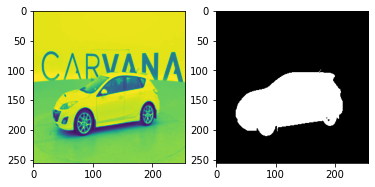

In [10]:
image, mask = next(iter(train_loader))
plt.subplot(121)
plt.imshow(image[0,0])
plt.subplot(122)
plt.imshow(mask[0,0], cmap="gray")

In [11]:
# 使用Binary Cross Entropy Loss，之后我们会尝试替换为自定义的loss
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(unet.parameters(), lr=1e-3, weight_decay=1e-8)

unet = nn.DataParallel(unet).cuda()

In [12]:
def dice_coeff(pred, target):
    eps = 0.0001
    num = pred.size(0)
    m1 = pred.view(num, -1)  # Flatten
    m2 = target.view(num, -1)  # Flatten
    intersection = (m1 * m2).sum()
    return (2. * intersection + eps) / (m1.sum() + m2.sum() + eps)

def train(epoch):
    unet.train()
    train_loss = 0
    for data, mask in train_loader:
        data, mask = data.cuda(), mask.cuda()
        optimizer.zero_grad()
        output = unet(data)
        loss = criterion(output,mask)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

def val(epoch):  
    print("current learning rate: ", optimizer.state_dict()["param_groups"][0]["lr"])
    unet.eval()
    val_loss = 0
    dice_score = 0
    with torch.no_grad():
        for data, mask in val_loader:
            data, mask = data.cuda(), mask.cuda()
            output = unet(data)
            loss = criterion(output, mask)
            val_loss += loss.item()*data.size(0)
            dice_score += dice_coeff(torch.sigmoid(output).cpu(), mask.cpu())*data.size(0)
    val_loss = val_loss/len(val_loader.dataset)
    dice_score = dice_score/len(val_loader.dataset)
    print('Epoch: {} \tValidation Loss: {:.6f}, Dice score: {:.6f}'.format(epoch, val_loss, dice_score))

In [40]:
epochs = 100
for epoch in range(1, epochs+1):
    train(epoch)
    val(epoch)

Epoch: 1 	Training Loss: 0.179544
current learning rate:  0.001
Epoch: 1 	Validation Loss: 0.142780, Dice score: 0.774944
Epoch: 2 	Training Loss: 0.060674
current learning rate:  0.001
Epoch: 2 	Validation Loss: 0.054721, Dice score: 0.909441
Epoch: 3 	Training Loss: 0.033283
current learning rate:  0.001
Epoch: 3 	Validation Loss: 0.034448, Dice score: 0.945890
Epoch: 4 	Training Loss: 0.023393
current learning rate:  0.001


KeyboardInterrupt: 

In [41]:
!nvidia-smi

Sun Mar 27 20:57:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:18:00.0 Off |                  N/A |
| 27%   30C    P8     6W / 250W |   1126MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:3B:00.0 Off |                  N/A |
| 27%   

**Point 5：自定义损失函数**  
如果我们不想使用交叉熵函数，而是想针对分割模型常用的Dice系数设计专门的loss，即DiceLoss，这时就需要我们自定义PyTorch的损失函数

In [42]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()
        
    def forward(self,inputs,targets,smooth=1):
        inputs = torch.sigmoid(inputs)       
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()                   
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        return 1 - dice


In [43]:
newcriterion = DiceLoss()

unet.eval()
image, mask = next(iter(val_loader))
out_unet = unet(image.cuda())
loss = newcriterion(out_unet, mask.cuda())
print(loss)

tensor(0.1071, device='cuda:0', grad_fn=<RsubBackward1>)


**Point 6：动态调整学习率**  
随着优化的进行，固定的学习率可能无法满足优化的需求，这时需要调整学习率，降低优化的速度  
这里演示使用PyTorch自带的StepLR scheduler动态调整学习率的效果，文字版教程中给出了自定义scheduler的方式

In [13]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)

In [14]:
epochs = 100
for epoch in range(1, epochs+1):
    train(epoch)
    val(epoch)
    scheduler.step()

Epoch: 1 	Training Loss: 0.177876
current learning rate:  0.001
Epoch: 1 	Validation Loss: 1.773043, Dice score: 0.432005
Epoch: 2 	Training Loss: 0.056940
current learning rate:  0.0008
Epoch: 2 	Validation Loss: 0.061336, Dice score: 0.906578
Epoch: 3 	Training Loss: 0.042535
current learning rate:  0.00064


KeyboardInterrupt: 

In [15]:
?optim.lr_scheduler.StepLR

**Point 7：模型微调**

In [16]:
unet

DataParallel(
  (module): UNet(
    (inc): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (down1): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(128, 128, 

In [22]:
unet.module.outc.conv.weight.requires_grad = False
unet.module.outc.conv.bias.requires_grad = False

for layer, param in unet.named_parameters():
    print(layer, '\t', param.requires_grad)

module.inc.double_conv.0.weight 	 True
module.inc.double_conv.1.weight 	 True
module.inc.double_conv.1.bias 	 True
module.inc.double_conv.3.weight 	 True
module.inc.double_conv.4.weight 	 True
module.inc.double_conv.4.bias 	 True
module.down1.maxpool_conv.1.double_conv.0.weight 	 True
module.down1.maxpool_conv.1.double_conv.1.weight 	 True
module.down1.maxpool_conv.1.double_conv.1.bias 	 True
module.down1.maxpool_conv.1.double_conv.3.weight 	 True
module.down1.maxpool_conv.1.double_conv.4.weight 	 True
module.down1.maxpool_conv.1.double_conv.4.bias 	 True
module.down2.maxpool_conv.1.double_conv.0.weight 	 True
module.down2.maxpool_conv.1.double_conv.1.weight 	 True
module.down2.maxpool_conv.1.double_conv.1.bias 	 True
module.down2.maxpool_conv.1.double_conv.3.weight 	 True
module.down2.maxpool_conv.1.double_conv.4.weight 	 True
module.down2.maxpool_conv.1.double_conv.4.bias 	 True
module.down3.maxpool_conv.1.double_conv.0.weight 	 True
module.down3.maxpool_conv.1.double_conv.1.weight 	

In [23]:
param

Parameter containing:
tensor([-0.1994], device='cuda:0')

**Point 8：半精度训练**

In [9]:
## 演示时需要restart kernel，并运行Unet模块

from torch.cuda.amp import autocast
os.environ['CUDA_VISIBLE_DEVICES'] = '2,3'

In [10]:
class CarvanaDataset(Dataset):
    def __init__(self, base_dir, idx_list, mode="train", transform=None):
        self.base_dir = base_dir
        self.idx_list = idx_list
        self.images = os.listdir(base_dir+"train")
        self.masks = os.listdir(base_dir+"train_masks")
        self.mode = mode
        self.transform = transform
    
    def __len__(self):
        return len(self.idx_list)

    def __getitem__(self, index):
        image_file = self.images[self.idx_list[index]]
        mask_file = image_file[:-4]+"_mask.gif"
        image = PIL.Image.open(os.path.join(base_dir, "train", image_file))
        if self.mode=="train":
            mask = PIL.Image.open(os.path.join(base_dir, "train_masks", mask_file))
            if self.transform is not None:
                image = self.transform(image)
                mask = self.transform(mask)
                mask[mask!=0] = 1.0
            return image, mask.float()
        else:
            if self.transform is not None:
                image = self.transform(image)
            return image

base_dir = "./"
transform = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])
train_idxs, val_idxs = train_test_split(range(len(os.listdir(base_dir+"train_masks"))), test_size=0.3)
train_data = CarvanaDataset(base_dir, train_idxs, transform=transform)
val_data = CarvanaDataset(base_dir, val_idxs, transform=transform)
train_loader = DataLoader(train_data, batch_size=32, num_workers=4, shuffle=True)
val_loader = DataLoader(train_data, batch_size=32, num_workers=4, shuffle=False)
    

In [11]:
class UNet_half(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet_half, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
    
    @autocast()
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

unet_half = UNet_half(3,1)
unet_half = nn.DataParallel(unet_half).cuda()

In [12]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(unet_half.parameters(), lr=1e-3, weight_decay=1e-8)

In [13]:
def dice_coeff(pred, target):
    eps = 0.0001
    num = pred.size(0)
    m1 = pred.view(num, -1)  # Flatten
    m2 = target.view(num, -1)  # Flatten
    intersection = (m1 * m2).sum()
    return (2. * intersection + eps) / (m1.sum() + m2.sum() + eps)

def train_half(epoch):
    unet_half.train()
    train_loss = 0
    for data, mask in train_loader:
        data, mask = data.cuda(), mask.cuda()
        with autocast():
            optimizer.zero_grad()
            output = unet_half(data)
            loss = criterion(output,mask)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

def val_half(epoch):  
    print("current learning rate: ", optimizer.state_dict()["param_groups"][0]["lr"])
    unet_half.eval()
    val_loss = 0
    dice_score = 0
    with torch.no_grad():
        for data, mask in val_loader:
            data, mask = data.cuda(), mask.cuda()
            with autocast():
                output = unet_half(data)
                loss = criterion(output, mask)
                val_loss += loss.item()*data.size(0)
                dice_score += dice_coeff(torch.sigmoid(output).cpu(), mask.cpu())*data.size(0)
    val_loss = val_loss/len(val_loader.dataset)
    dice_score = dice_score/len(val_loader.dataset)
    print('Epoch: {} \tValidation Loss: {:.6f}, Dice score: {:.6f}'.format(epoch, val_loss, dice_score))

In [15]:
epochs = 100
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)
for epoch in range(1, epochs+1):
    train_half(epoch)
    val_half(epoch)
    scheduler.step()

Epoch: 1 	Training Loss: 0.431690
current learning rate:  0.001
Epoch: 1 	Validation Loss: 0.399930, Dice score: 0.000200


KeyboardInterrupt: 

In [16]:
!nvidia-smi

Sun Mar 27 21:17:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:18:00.0 Off |                  N/A |
| 49%   49C    P2    52W / 250W |   8989MiB / 11019MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:3B:00.0 Off |                  N/A |
| 59%   